<h1>Sentiment Analysis of IMDB Movie Reviews<h1>

<h2>Problem Statement</h2>

NLP Challenge: IMDB Dataset of 50K Movie Reviews to perform Sentiment analysis

Do a thorough Exploratory Data Analysis of the dataset and report the final performance metrics for your approach. Suggest ways in which you can improve the model.

**Initial considerations**:
1. Preprocessing Challenges: Handling abbreviations, emojis, slang and html tags could be challenging
2. Imbalanced Data: Ensuring that the dataset is balanced regarding positive and negative reviews.
3. Overfitting: Complex models might overfit the training data, making it less generalizable

**Import basic libraries**

In [20]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import os
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/shansita-
[nltk_data]     dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shansita-
[nltk_data]     dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shansita-
[nltk_data]     dev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Import the training dataset**

In [2]:
data = pd.read_csv(os.path.join('input', 'IMDB Dataset.csv'))

# Display the first few rows of the dataset
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<h2>Exploratory Data Analysis</h2>

- Balance of positive and negative reviews

- Most frequently appearing tokens

- Worldcloud

Value counts of each category:
positive    25000
negative    25000
Name: sentiment, dtype: int64


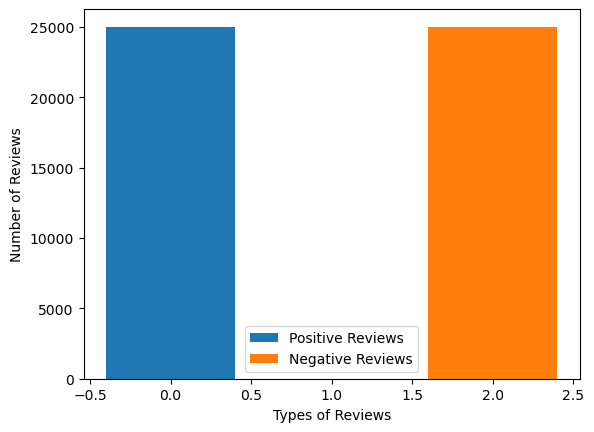

In [3]:
#Count of good and bad reviews
print(f"Value counts of each category:\n{data['sentiment'].value_counts()}")

reviews_pos, reviews_neg = data[data['sentiment']=='positive'], data[data['sentiment']=='negative']

plt.bar(0,len(reviews_pos),label='Positive Reviews')
plt.bar(2,len(reviews_neg),label='Negative Reviews')
plt.legend()
plt.ylabel('Number of Reviews')
plt.xlabel('Types of Reviews')
plt.show()

Evidently, the dataset is balanced in the number of reviews in each category

**Wordclouds**

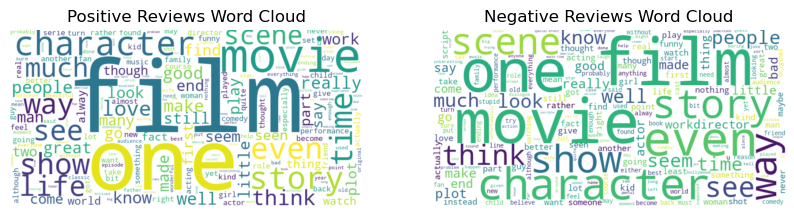

In [32]:
"""
Generate wordcloud
"""

# Generate word cloud for positive reviews
positive_reviews = ' '.join(data[data['sentiment'] == 1]['cleaned_review'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Generate word cloud for negative reviews
negative_reviews = ' '.join(data[data['sentiment'] == 0]['cleaned_review'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show()

**Token frequencies**

<Axes: >

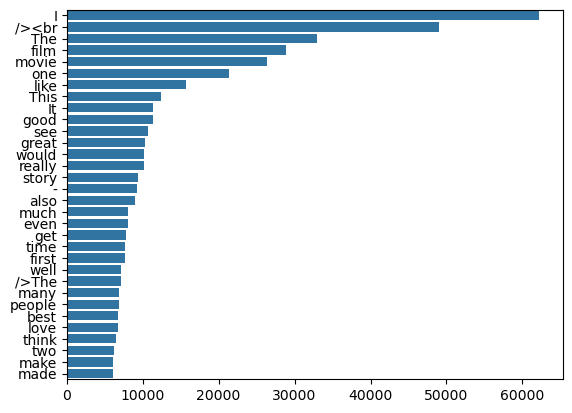

In [4]:
stop_words = set(stopwords.words('english'))

def create_corpus(word):
    corpus=[]

    for x in data[data['sentiment']==word]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus('positive')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stop_words) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

The appears to be a large number of tokens that would not contribute to the sentiment prediction and would only distract the model from the motive. These must be removed during the preprocessing/cleaning process.

<h2>Preprocessing & Cleaning Steps</h2>

- **HTML Tag Removal**: Remove all html </..> tags

- **Lowercasing**: Convert all characters to lowercase to ensure uniformity.

- **Stop Words Removal**: Remove common words that don't contribute much to the sentiment.

- **Stemming/Lemmatization**: Reduce words to their base or root form.

- **Punctuation Removal**: Remove punctuation marks.

- **Handling Special Characters and Numbers**: Decide whether to remove or keep special characters and numbers based on their relevance.

- **Text Normalization**: Expand contractions (e.g., "don't" to "do not").

In [5]:
def remove_punctuation(text):
    """
    Remove punctuation from the given text.
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_urls(text):
    """
    Remove URLs from the given text.
    """
    # Regular expression to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_special_characters(text):
    """
    Remove special characters and emojis from the given text.
    """
    # Regular expression to match special characters and emojis
    special_char_pattern = re.compile(r'[^A-Za-z0-9\s]+')
    return special_char_pattern.sub(r'', text)

def remove_html_tags(text):
    """
    Remove HTML tags from the given text.
    """
    # Use regular expression to remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', text)
    return clean_text


In [6]:
# Dictionary of contractions and their expanded forms
contractions_dict = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "wouldn't": "would not",
    "shan't": "shall not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not"
}

# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text):
    """
    Expand contractions in the given text.
    """
    def replace(match):
        return contractions_dict[match.group(0)]

    return contractions_re.sub(replace, text)

In [7]:
# Define stop words
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    """
    Remove stop words from the given text.
    """
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Join tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [8]:
# Initialize the stemmer and lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    """
    Perform lemmatization on the given text.
    """
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [9]:
def denoise_text(text):
    """
    Clean and preprocess text by performing all preprocessing steps.
    """
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)

    # Remove URLs
    text = remove_urls(text)

    # Remove HTML tags
    text = remove_html_tags(text)

    # Remove punctuation
    text = remove_punctuation(text)

    # Remove special characters and emojis
    text = remove_special_characters(text)

    # Remove stop words
    text = remove_stop_words(text)

    # Perform lemmatization
    text = lemmatize_text(text)

    return text

In [10]:
# Apply preprocessing to the 'review' column
data['cleaned_review'] = data['review'].apply(denoise_text)
# Fix data type
data['sentiment'] = data['sentiment'].replace({'positive': 1, 'negative': 0})

data.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...


In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

<h2>Feature Engineering</h2>

We can explore the following forms of feature engineering for this problem

- N-grams: Including bigrams or trigrams can capture more contextual information.

- Part-of-Speech Tagging: Use POS tags to enhance features, as certain parts of speech may carry more sentiment.

- Sentiment Lexicons: Incorporate external sentiment lexicons to enrich the feature set.

- TF-IDF: Use Term Frequency-Inverse Document Frequency to weigh the importance of words.

- Word Embeddings: Pre-trained embeddings like GloVe or Word2Vec can capture semantic meaning and improve model performance.

I decided to test out 3 of these methods:

- A deep learning model that utilizes **pre-training embeddings**: Model #1

- A classical model that utilizes **TF-IDF vectorization with n-grams**: Model #2

- POS tagging: Due to computational limitations, it was taking too long to complete running this code, so I eliminated this method


<h2>Model #1: Bidirectional RNN with Embeddings</h2>

**Tokenization**

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words and sequence length
max_words = 5000
max_len = 100

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**Word2Vec Embeddings**

In [13]:
import gensim.downloader as api

# Load pre-trained Word2Vec model
word2vec = api.load('word2vec-google-news-300')

# Define the embedding dimension
embedding_dim = 300

# Create a dictionary to map words to their Word2Vec embeddings
embedding_index = {word: word2vec[word] for word in word2vec.index_to_key}

# Create the embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**Model Architecture and Training**

In [15]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_rnn_model(hp):
    """
    Parameterized bidirectional rnn model build function
    """
    model = Sequential()
    model.add(Embedding(input_dim=num_words, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False))
    
    # Tune the number of LSTM units in the first layer
    model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True)))
    
    # Tune the dropout rate in the first layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Tune the number of LSTM units in the second layer
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=16, max_value=64, step=16))))
    
    # Tune the dropout rate in the second layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

**Hyperparameter Optimization**

In [16]:
import keras_tuner as kt

# Instantiate the Keras Tuner
tuner = kt.Hyperband(
    build_rnn_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='imdb_sentiment_analysis'
)

# Run the hyperparameter search
tuner.search(X_train_pad, y_train, 
             epochs=10, 
             validation_data=(X_test_pad, y_test),
             batch_size=64)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best Hyperparameters: {best_hp.values}')

# Build the model with the best hyperparameters
best_rnn_model = tuner.hypermodel.build(best_hp)

INFO:tensorflow:Reloading Tuner from hyperband/imdb_sentiment_analysis/tuner0.json
INFO:tensorflow:Oracle triggered exit
Best Hyperparameters: {'units_1': 64, 'dropout_1': 0.30000000000000004, 'units_2': 48, 'dropout_2': 0.4, 'learning_rate': 0.01, 'tuner/epochs': 4, 'tuner/initial_epoch': 2, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0001'}


**Train and save the best model**

In [17]:
history = best_rnn_model.fit(X_train_pad, y_train, epochs=4, validation_data=(X_test_pad, y_test), batch_size=64)

Epoch 1/4


2024-06-29 23:31:44.007733: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


625/625 [==============================] - 110s 172ms/step - loss: 0.3882 - accuracy: 0.8277 - val_loss: 0.3748 - val_accuracy: 0.8281
Epoch 2/4
625/625 [==============================] - 117s 187ms/step - loss: 0.3076 - accuracy: 0.8727 - val_loss: 0.2924 - val_accuracy: 0.8741
Epoch 3/4
625/625 [==============================] - 112s 179ms/step - loss: 0.2754 - accuracy: 0.8876 - val_loss: 0.2934 - val_accuracy: 0.8747
Epoch 4/4
625/625 [==============================] - 107s 171ms/step - loss: 0.2417 - accuracy: 0.9013 - val_loss: 0.2897 - val_accuracy: 0.8805


In [18]:
# Define the file path to save the model
best_rnn_model_path = os.path.join('models', 'bidirectional_lstm_model_best.keras')

best_rnn_model.save(best_rnn_model_path)

**Evaluation**

313/313 [==============================] - 12s 35ms/step
Accuracy: 0.8805
Precision: 0.8640151515151515
Recall: 0.9053383607858703
F1 Score: 0.8841942048648125
ROC-AUC: 0.9501341661626693
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4961
           1       0.86      0.91      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



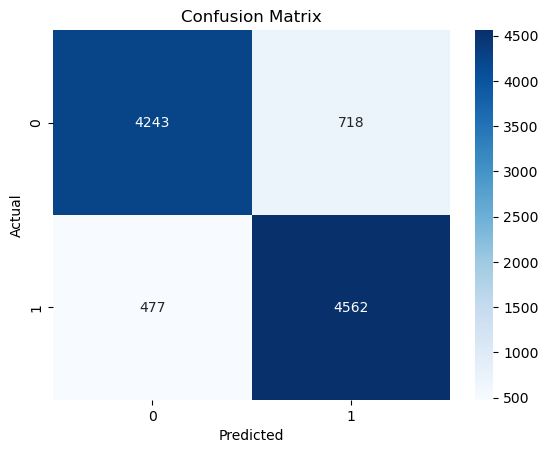

In [33]:
model = load_model(best_rnn_model_path)

# Predict on the test data
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

"""
1. Generate evaluation metrics
"""

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

# Print classification report
print(classification_report(y_test, y_pred))

"""
2. Generate confusion matrix
"""

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h2>Model #2: Logstic Regression with TF-DIF Vectorization</h2>

**TF-IDF Vectorization**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

**Model Training**

In [23]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)

LogisticRegression()

**Hyperparameter Optimization**

In [24]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

# Train the model with the best parameters
best_logreg_model = grid_search.best_estimator_

Best Parameters: {'C': 1, 'penalty': 'l2'}
Best Score: 0.884


**Save best model**

In [25]:
# Save the model and TF-IDF vectorizer
logreg_model_path = os.path.join('models', 'logreg_vec_model.pkl')
tfidf_vec_path = os.path.join('models', 'tfidf_vectorizer.pkl')
joblib.dump(best_logreg_model, logreg_model_path)
joblib.dump(tfidf_vectorizer, tfidf_vec_path)

['models/tfidf_vectorizer.pkl']

**Evaluation**

Accuracy: 0.8853
Precision: 0.8764023210831722
Recall: 0.8991863464973209
F1 Score: 0.8876481535899696
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



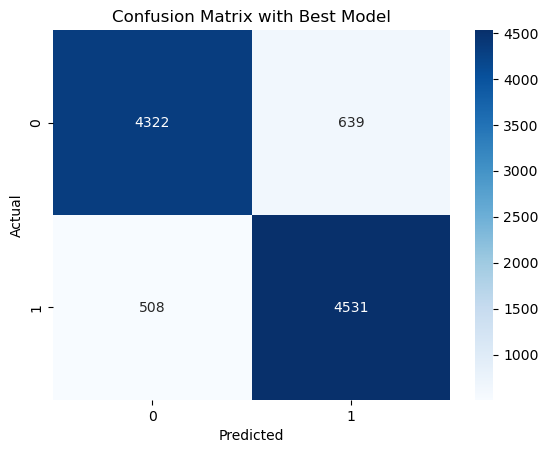

In [30]:
# Open the file in read-binary mode
with open(logreg_model_path, 'rb') as file:
    logreg_model = joblib.load(logreg_model_path)

# Predict on the test data with the best model
y_pred = logreg_model.predict(X_test_tfidf)

"""
1. Generate evaluation metrics
"""

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print classification report
print(classification_report(y_test, y_pred))


"""
2. Generate confusion matrix
"""

# Plot confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Best Model')
plt.show()